In this notebook, we fully train, in an end-to-end manner, the architectures designed in the previous notebook: *Reduce dimensionality: architectures.ipynb*.
As a reminder, the end-to-end training procedure gives  an approx. 92% testing acc on the legacy AnalogNet architecture.


In [0]:
#############################################
# TRAINING HYPERPARAMETERS
#############################################

EPOCHS = 50
BATCH_SIZE = 100
LR = 0.001

# Output binarization
MAX_BIN_RATE = 1000

# Define regularizers
ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.

REG_CONSTANT = 25.

# 0. Import Data / Utils functions

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))

# 1. Network definition and training

## 1.1 Network Definition:

In [0]:
def binarize_tensor_differentiable_one_thresh(input, thresh, bin_rate):
  return tf.nn.sigmoid(bin_rate*(input - thresh))

In [0]:
def network(input, bin_rate_ph, thresh):
  # Convolution
  conv1 = slim.conv2d(input, 4, [3, 3], rate=1, activation_fn=tf.nn.relu,
                     padding='SAME', scope='conv1')
  

  # DIMENSIONALITY REDUCTION:
  #  avg or max pooling or sampling or no pooling?
  conv1 = slim.max_pool2d(conv1, [2, 2], 
                         stride=[2, 2], padding='SAME')
  
  # Second conv layer
  conv2 = slim.conv2d(conv1, 8, [3, 3], rate=1, activation_fn=None,
                      biases_initializer=None,
                      padding='SAME', scope='conv2')
  
  # Simulating output binarisation
  conv2_bin = binarize_tensor_differentiable_one_thresh(conv2,
                                                        thresh, bin_rate_ph)
  
  # Sum pooling
  pool = slim.avg_pool2d(conv2_bin, [9, 9], 
                         stride=[9, 9], padding='SAME') * 9*9
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 10, name='dense2')
  
  return out

In [0]:
## Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,28,28,1])
bin_rate_ph = tf.placeholder(tf.float32, ())
gt_label_ph = tf.placeholder(tf.uint8)

thresh = tf.Variable(3+tf.random.normal([8]), name='out_thresholds')

out_label_op = network(in_image_ph, bin_rate_ph, thresh)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')
  b1 = tf.get_variable('biases')
with tf.variable_scope('conv2', reuse=True) as scope_conv:
  w2 = tf.get_variable('weights')

In [0]:
params_w1 = np.prod(([int(e) for e in w1.shape]))
params_b1 = np.prod(([int(e) for e in b1.shape]))
params_w2 = np.prod(([int(e) for e in w2.shape]))
params_t = np.prod(([int(e) for e in thresh.shape]))
params_total = params_w1 + params_b1 + params_w2 + params_t

In [0]:
reg_losses = params_w1 *tf.reduce_mean(customRegularizerConv(w1))
reg_losses += params_b1 *tf.reduce_mean(customRegularizerBias(b1))
reg_losses += params_w2 *tf.reduce_mean(customRegularizerConv(w2))
reg_losses += params_t *tf.reduce_mean(customRegularizerBias(thresh))
reg_losses *= 1/params_total

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)

opt_with_reg = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_with_reg_op = opt_with_reg.minimize(loss_with_reg_op)

sess.run(tf.variables_initializer(opt_with_reg.variables()))

## 1.2 Training Loop

In [0]:
# Previous schedules:
  if epoch < EPOCHS * 2:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 4:
    lr_feed = LR / 2.
    reg_factor_feed = 0
    bin_rate_feed = adaptative_factor(epoch - EPOCHS * 2, EPOCHS * 2)
    bin_rate_feed = MAX_BIN_RATE*bin_rate_feed + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 2)
    reg_factor_feed *= REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
# Long, brutal training, reg then bin
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1

# Long, brutal training, bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = 0
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
    
# binarization only (without custom reg)
for epoch in range(EPOCHS*8):
  reg_factor_feed = 0
  if epoch < EPOCHS * 4:
    lr_feed = LR
    bin_rate_feed = 1.
  else:
    lr_feed = LR / 2.
    bin_rate_feed = MAX_BIN_RATE
    
# custom reg only (without binarization)
for epoch in range(EPOCHS*8):
  bin_rate_feed = 1.
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0
  else:
    lr_feed = LR / 2.
    reg_factor_feed = REG_CONSTANT


In [22]:
# Long, brutal training, bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    #reg_factor_feed = adaptative_factor(epoch - EPOCHS * 4, EPOCHS * 4)
    reg_factor_feed = 0
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    #bin_rate_feed = adaptative_factor(epoch - EPOCHS * 8, EPOCHS * 4)
    bin_rate_feed = MAX_BIN_RATE + 1
      
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_with_reg_op, loss_with_reg_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.551198027531306
Testing Acc.: 0.8576999998092651
Epoch 2 completed, average training loss is 0.36757758622368175
Testing Acc.: 0.9145999997854233
Epoch 3 completed, average training loss is 0.2679368135581414
Testing Acc.: 0.9328000050783157
Epoch 4 completed, average training loss is 0.21753744778533776
Testing Acc.: 0.9445000040531158
Epoch 5 completed, average training loss is 0.19055040993417302
Testing Acc.: 0.9460000038146973
Epoch 6 completed, average training loss is 0.174289295108368
Testing Acc.: 0.949200005531311
Epoch 7 completed, average training loss is 0.1609409128812452
Testing Acc.: 0.9507000070810318
Epoch 8 completed, average training loss is 0.15221682044056556
Testing Acc.: 0.9533000057935714
Epoch 9 completed, average training loss is 0.1457593734872838
Testing Acc.: 0.9576000040769577
Epoch 10 completed, average training loss is 0.13857365472552677
Testing Acc.: 0.9563000029325486
Epoch 11 completed, average training 

In [23]:
test_accuracy_bin_rate(5000)

Testing Acc.: 0.9528000026941299


In [24]:
# Save model, for not having to fully retrain it each time.
saver = tf.train.Saver()
saver.save(sess, 'maxpool/model.ckpt')

'maxpool/model.ckpt'

In [25]:
!zip -r maxpool.zip maxpool

  adding: maxpool/ (stored 0%)
  adding: maxpool/checkpoint (deflated 42%)
  adding: maxpool/model.ckpt.index (deflated 44%)
  adding: maxpool/model.ckpt.data-00000-of-00001 (deflated 12%)
  adding: maxpool/model.ckpt.meta (deflated 87%)


In [26]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_bias1_op = tf.assign(b1,
                          tf.round(b1/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)
rounding_weights2_op = tf.assign(w2, 
                          tf.round(w2/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)
rounding_t_op = tf.assign(thresh,
                          tf.round(thresh/ROUNDING_STEP_BIAS)*ROUNDING_STEP_BIAS)

_ = sess.run([rounding_weights1_op, rounding_bias1_op])
_ = sess.run([rounding_weights2_op, rounding_t_op])

# Accuracy with rounded weights:
test_accuracy_bin_rate(5000)

Testing Acc.: 0.9417000025510788


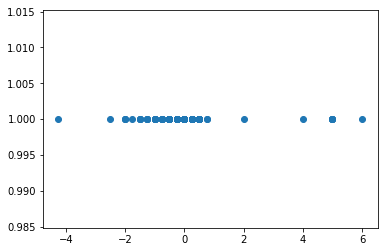

In [27]:
# Show distribution of weights after rounding
w1_values, b1_values = sess.run([w1, b1])
w2_values = sess.run(w2)
thresh_values = sess.run(thresh)

kernel_values = (list(w1_values.flatten()) + list(b1_values.flatten())
                + list(w2_values.flatten())
                + list(thresh_values.flatten()) )

fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))

In [0]:
with open('NP_WEIGHTS.pck', 'wb') as f:
  pickle.dump((w1_values, b1_values, w2_values, thresh_values), f)

## 1.3 Retraining only FC

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

opt_only_fc_op = opt_with_reg.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                                          fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_with_reg.variables()))

In [30]:
bin_rate_feed = MAX_BIN_RATE + 1

for epoch in range(EPOCHS*2):
  if epoch < EPOCHS:
    lr_feed = LR
  else:
    lr_feed = LR / 4.

  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]

    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]

    _, current_loss = sess.run([opt_only_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss

  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

test_acc_after_fc_retrain = test_accuracy_bin_rate(MAX_BIN_RATE + 1)


Epoch 1 completed, average training loss is 0.13468369495434065
Testing Acc.: 0.9516000062227249
Epoch 2 completed, average training loss is 0.13285441918298602
Testing Acc.: 0.9514000052213669
Epoch 3 completed, average training loss is 0.1323116242295752
Testing Acc.: 0.9498000031709671
Epoch 4 completed, average training loss is 0.13214120538284382
Testing Acc.: 0.9484000033140183
Epoch 5 completed, average training loss is 0.13335040671440462
Testing Acc.: 0.947200003862381
Epoch 6 completed, average training loss is 0.13332526868830125
Testing Acc.: 0.9438000041246414
Epoch 7 completed, average training loss is 0.1328279864555225
Testing Acc.: 0.9514000052213669
Epoch 8 completed, average training loss is 0.13234003456309437
Testing Acc.: 0.951300003528595
Epoch 9 completed, average training loss is 0.13320355685738225
Testing Acc.: 0.9493000042438507
Epoch 10 completed, average training loss is 0.13297378891768555
Testing Acc.: 0.9501000046730042
Epoch 11 completed, average train

In [0]:
test_accuracy_bin_rate(5000)

Testing Acc.: 0.8299999982118607
Testing Acc.: 0.8299999982118607
